In [1]:
import cfbd
import numpy as np
import pandas as pd

from fastai.tabular import *
from fastai.tabular.all import *

In [2]:
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = ''
configuration.api_key_prefix['Authorization'] = 'Bearer'

api_config = cfbd.ApiClient(configuration)

In [3]:
teams_api = cfbd.TeamsApi(api_config)
ratings_api = cfbd.RatingsApi(api_config)
games_api = cfbd.GamesApi(api_config)
stats_api = cfbd.StatsApi(api_config)
betting_api = cfbd.BettingApi(api_config)

In [4]:
games = []
lines = []

for year in range(2015, 2022):
    response = games_api.get_games(year=year)
    games = [*games, *response]
    
    response = betting_api.get_lines(year=year)
    lines = [*lines, *response]

In [5]:
games = [g for g in games if g.home_conference is not None and g.away_conference is not None and g.home_points is not None and g.away_points is not None]
len(games)

10443

In [6]:
games[0]

{'attendance': None,
 'away_conference': 'MVFC',
 'away_division': 'fcs',
 'away_id': 2449,
 'away_line_scores': [7, 21, 0, 7],
 'away_points': 35,
 'away_post_win_prob': None,
 'away_postgame_elo': None,
 'away_pregame_elo': None,
 'away_team': 'North Dakota State',
 'completed': True,
 'conference_game': False,
 'excitement_index': None,
 'highlights': None,
 'home_conference': 'Big Sky',
 'home_division': 'fcs',
 'home_id': 149,
 'home_line_scores': [10, 11, 7, 10],
 'home_points': 38,
 'home_post_win_prob': None,
 'home_postgame_elo': None,
 'home_pregame_elo': None,
 'home_team': 'Montana',
 'id': 400795501,
 'neutral_site': False,
 'notes': None,
 'season': 2015,
 'season_type': 'regular',
 'start_date': '2015-08-29T19:30:00.000Z',
 'start_time_tbd': False,
 'venue': 'Washington-Grizzly Stadium',
 'venue_id': 3987,
 'week': 1}

In [7]:
games = [
    dict(
        id = g.id,
        year = g.season,
        week = g.week,
        neutral_site = g.neutral_site,
        home_team = g.home_team,
        home_conference = g.home_conference,
        home_points = g.home_points,
        home_elo = g.home_pregame_elo,
        away_team = g.away_team,
        away_conference = g.away_conference,
        away_points = g.away_points,
        away_elo = g.away_pregame_elo
    ) for g in games]

games[0]

{'id': 400795501,
 'year': 2015,
 'week': 1,
 'neutral_site': False,
 'home_team': 'Montana',
 'home_conference': 'Big Sky',
 'home_points': 38,
 'home_elo': None,
 'away_team': 'North Dakota State',
 'away_conference': 'MVFC',
 'away_points': 35,
 'away_elo': None}

In [8]:
lines[0]

{'away_conference': 'Mid-American',
 'away_score': 48,
 'away_team': 'Eastern Michigan',
 'home_conference': 'Mountain West',
 'home_score': 29,
 'home_team': 'Wyoming',
 'id': 400787119,
 'lines': [{'away_moneyline': None,
            'formatted_spread': 'Wyoming -13',
            'home_moneyline': None,
            'over_under': 52.0,
            'over_under_open': None,
            'provider': 'teamrankings',
            'spread': -13.0,
            'spread_open': None},
           {'away_moneyline': None,
            'formatted_spread': 'Wyoming -11.5',
            'home_moneyline': None,
            'over_under': 52.0,
            'over_under_open': None,
            'provider': 'numberfire',
            'spread': -11.5,
            'spread_open': None},
           {'away_moneyline': None,
            'formatted_spread': 'Wyoming -11',
            'home_moneyline': None,
            'over_under': nan,
            'over_under_open': None,
            'provider': 'consensus',
      

In [11]:
for game in games:
    game_lines = [l for l in lines if l.id == game['id']]
    
    if len(game_lines) > 0:
        game_line = [l for l in game_lines[0].lines if l.provider == 'consensus']
        
        if len(game_line) > 0 and game_line[0].spread is not None:
            game['spread'] = float(game_line[0].spread)

In [12]:
games = [g for g in games if 'spread' in g and g['spread'] is not None]

len(games)

5372

In [13]:
for game in games:
    game['margin'] = game['away_points'] - game['home_points']

In [14]:
df = pd.DataFrame.from_records(games).dropna()
df.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,spread,margin
0,400763593,2015,1,False,UCF,American Athletic,14,1626.0,Florida International,Conference USA,15,1321.0,-17.0,1
1,400603840,2015,1,True,South Carolina,SEC,17,1646.0,North Carolina,ACC,13,1477.0,-3.5,-4
2,400763399,2015,1,False,Central Michigan,Mid-American,13,1417.0,Oklahoma State,Big 12,24,1567.0,20.5,11
3,400603839,2015,1,False,Vanderbilt,SEC,12,1365.0,Western Kentucky,Conference USA,14,1521.0,-17.5,2
4,400756883,2015,1,False,Utah,Pac-12,24,1603.0,Michigan,Big Ten,17,1553.0,-3.0,-7


In [15]:
test_df = df.query("year == 2021")
train_df = df.query("year != 2021")

In [16]:
excluded = ['id','year','week','home_team','away_team','margin', 'home_points', 'away_points']
cat_features = ['home_conference','away_conference','neutral_site']
cont_features = [c for c in df.columns.to_list() if c not in cat_features and c not in excluded]

cont_features

['home_elo', 'away_elo', 'spread']

In [17]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
splits

((#3230) [170,764,3547,738,1944,2066,1479,836,1308,3882...],
 (#807) [2294,2253,3004,2016,2602,478,2601,3881,3841,985...])

In [18]:
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                    y_names="margin",
                    cat_names = cat_features,
                    cont_names = cont_features,
                   splits=splits)

/opt/conda/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/opt/conda/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
/opt/conda/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
/opt/conda/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


In [19]:
dls = to.dataloaders(bs=128)
dls.show_batch()

,home_conference,away_conference,neutral_site,home_elo,away_elo,spread,margin
0,Mid-American,Mid-American,False,1434.999998,1761.000014,10.500000,41.0
1,SEC,Sun Belt,False,1764.000004,1448.000000,-20.500000,3.0
2,ACC,ACC,False,1420.000000,1475.000000,-1.000000,24.0
3,Conference USA,Conference USA,False,1525.000000,1392.999997,-10.000000,-5.0
4,Mountain West,Mountain West,False,1345.000007,1803.000010,13.500000,7.0
5,Big 12,Big 12,False,1434.999998,1025.000010,-31.500000,-39.0
6,Big Ten,Big Ten,False,1721.999999,1915.000008,3.500000,20.0
7,Big Ten,Big Ten,False,1765.000005,1903.999986,6.999999,38.0
8,Pac-12,Pac-12,False,1695.000007,1724.000006,-5.500000,-25.0
9,Mountain West,Mountain West,False,1345.000007,1438.999999,3.500000,-4.0


SuggestedLRs(valley=0.004365158267319202)

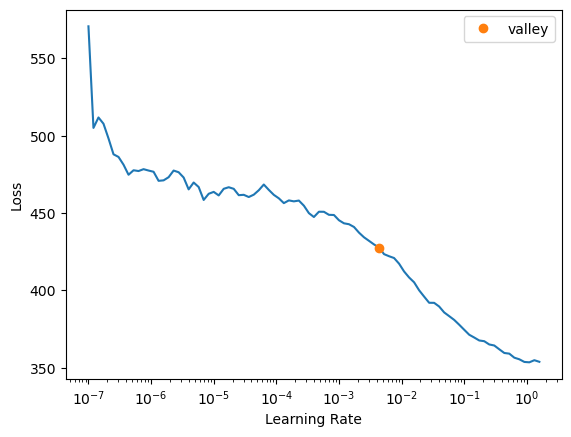

In [20]:
learn = tabular_learner(dls, metrics=mae, lr=10e-1)
learn.lr_find()

In [21]:
learn = tabular_learner(dls, metrics=mae, lr=10e-2)
learn.fit(10)

epoch,train_loss,valid_loss,mae,time
0,283.955139,304.049072,13.818340,00:00
1,268.673187,286.444611,13.398481,00:00
2,263.000031,276.975647,13.153657,00:00
3,259.823822,270.647400,13.008736,00:00
4,257.350067,274.057861,13.105052,00:00
5,256.936554,273.592651,13.140999,00:00
6,257.757233,271.251953,13.045007,00:00
7,257.569031,276.866791,13.125986,00:00
8,256.924896,272.510040,13.076243,00:00
9,256.799652,287.029449,13.421479,00:00


In [22]:
learn = tabular_learner(dls, metrics=mae, lr=10e-2)
learn.fit(4)

epoch,train_loss,valid_loss,mae,time
0,274.722626,322.400879,14.290863,00:00
1,266.003601,275.368195,13.119413,00:00
2,260.295135,272.322083,13.059522,00:00
3,258.324554,270.760834,13.017280,00:00


In [23]:
learn.show_results()

,home_conference,away_conference,neutral_site,home_elo,away_elo,spread,margin,margin_pred
0,3.0,3.0,1.0,0.052828,1.042690,0.929672,-19.0,9.160557
1,10.0,7.0,1.0,1.701501,-0.511948,-2.100901,-27.0,-30.850981
2,10.0,12.0,1.0,1.076279,-0.035462,-0.479897,-29.0,-11.478209
3,8.0,10.0,1.0,-0.998500,-0.956131,0.154409,51.0,-0.898825
4,11.0,13.0,1.0,-1.301155,0.739838,1.810652,21.0,25.151085
5,4.0,9.0,1.0,0.474952,-0.738078,-0.726572,-34.0,-16.031540
6,2.0,2.0,1.0,1.339111,0.602546,-0.444658,-12.0,-13.040280
7,1.0,1.0,1.0,0.498846,0.909435,1.105868,12.0,12.854911
8,2.0,2.0,1.0,0.243978,0.198743,-0.374179,-24.0,-11.264790


In [24]:
pdf = test_df.copy()
dl = learn.dls.test_dl(pdf)
pdf['predicted'] = learn.get_preds(dl=dl)[0].numpy()
pdf.head()

/opt/conda/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
/opt/conda/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
/opt/conda/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,spread,margin,predicted
4540,401282714,2021,1,False,Illinois,Big Ten,30,1392.0,Nebraska,Big Ten,22,1503.0,6.5,-8,7.373709
4541,401286187,2021,1,False,Fresno State,Mountain West,45,1465.0,UConn,FBS Independents,0,1223.0,-27.5,-45,-23.541103
4542,401309833,2021,1,False,UCLA,Pac-12,44,1517.0,Hawai'i,Mountain West,10,1466.0,-17.5,-34,-19.077259
4543,401282049,2021,1,False,New Mexico State,FBS Independents,3,1261.0,UTEP,Conference USA,30,1222.0,9.5,27,9.639548
4547,401300995,2021,1,False,UCF,American Athletic,36,1648.0,Boise State,Mountain West,31,1602.0,-6.5,-5,-8.954021


In [25]:
pdf[['home_team','away_team','spread','predicted']].round(1)

,home_team,away_team,spread,predicted
4540,Illinois,Nebraska,6.5,7.4
4541,Fresno State,UConn,-27.5,-23.5
4542,UCLA,Hawai'i,-17.5,-19.1
4543,New Mexico State,UTEP,9.5,9.6
4547,UCF,Boise State,-6.5,-9.0
...,...,...,...,...
5367,Cincinnati,Houston,-10.5,-13.6
5368,Wake Forest,Pittsburgh,3.5,2.0
5369,Iowa,Michigan,12.0,10.2
5370,California,USC,-4.5,-6.1


In [26]:
learn.export('talking_tech_neural_net')

In [27]:
load_learner('talking_tech_neural_net').get_preds(dl=dl)[0].numpy()

array([[  7.3737087 ],
       [-23.541103  ],
       [-19.07726   ],
       [  9.639548  ],
       [ -8.9540205 ],
       [ -9.588578  ],
       [-19.695127  ],
       [ 15.75076   ],
       [-32.746773  ],
       [  7.3019953 ],
       [-30.512318  ],
       [  8.21953   ],
       [ -5.224371  ],
       [ -4.673011  ],
       [-26.839575  ],
       [-17.3128    ],
       [ -1.5976477 ],
       [ -7.816604  ],
       [-29.78145   ],
       [-16.234997  ],
       [-18.060732  ],
       [-20.6647    ],
       [-22.007019  ],
       [ -6.12438   ],
       [ 20.940582  ],
       [  4.035365  ],
       [  2.229709  ],
       [-34.818905  ],
       [-19.191032  ],
       [-12.994674  ],
       [ -9.367224  ],
       [-16.152876  ],
       [ -8.537211  ],
       [ 14.001813  ],
       [ -3.9302242 ],
       [ -1.4884676 ],
       [-32.73362   ],
       [-18.806534  ],
       [-21.532093  ],
       [ -9.36371   ],
       [ -6.9875145 ],
       [-26.15775   ],
       [ -1.2688112 ],
       [  2